In [1]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 63.8 MB/s eta 0:00:00:00:0100:01


In [2]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00


In [3]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer
import faiss
from tqdm import tqdm

class ImageRetrieval:
    def __init__(self, model_name="hf-hub:timm/ViT-SO400M-14-SigLIP-384", device=None):
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Initialize SigLIP model and preprocessor
        self.model, self.preprocess = create_model_from_pretrained(model_name)
        self.model = self.model.to(self.device)
        self.model.eval()
        
        # Initialize FAISS index
        self.index = None
        self.image_paths = []

    def preprocess_images(self, image_paths):
        images = [self.preprocess(Image.open(path).convert("RGB")).unsqueeze(0) for path in image_paths]
        return torch.cat(images, dim=0).to(self.device)

    def extract_features(self, image_paths, batch_size=4):
        all_features = []
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting features"):
            batch_paths = image_paths[i:i+batch_size]
            images = self.preprocess_images(batch_paths)
            with torch.no_grad(), torch.cuda.amp.autocast():
                features = self.model.encode_image(images)
                features = F.normalize(features, dim=-1)
            all_features.append(features.cpu().numpy())
        
        return np.vstack(all_features)

    def build_index(self, image_directory):
        image_paths = []
        for root, _, files in os.walk(image_directory):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(root, file))
        
        print(f"Found {len(image_paths)} images. Building index...")
        features = self.extract_features(image_paths)
        
        self.index = faiss.IndexFlatIP(features.shape[1])
        self.index.add(features)
        self.image_paths = image_paths
        print("Index built successfully.")

    def search(self, query_image_path, k=5):
        query_feature = self.extract_features([query_image_path])
        D, I = self.index.search(query_feature, k)
        return [(self.image_paths[i], D[0][j]) for j, i in enumerate(I[0])]

    def search_with_text(self, text_query, k=5):
        tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
        text = tokenizer([text_query]).to(self.device)
        
        with torch.no_grad(), torch.cuda.amp.autocast():
            text_features = self.model.encode_text(text)
            text_features = F.normalize(text_features, dim=-1)
        
        D, I = self.index.search(text_features.cpu().numpy(), k)
        return [(self.image_paths[i], D[0][j]) for j, i in enumerate(I[0])]


In [4]:

# Initialize the image retrieval system
retriever = ImageRetrieval()



Using device: cuda


open_clip_pytorch_model.bin:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_loc

In [5]:
# Specify the directory containing your images
image_directory = '/kaggle/input/cutframe-aic24-l1314/Keyframes'

retriever.build_index(image_directory)



Found 37045 images. Building index...


Extracting features:   0%|          | 0/9262 [00:00<?, ?it/s]/tmp/ipykernel_30/3141306288.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Extracting features: 100%|██████████| 9262/9262 [48:57<00:00,  3.15it/s]


Index built successfully.


In [6]:
# Image-based search
query_image_path = '/kaggle/input/qb-123/flower_market_scene.jpeg'
print("Searching for similar images...")
results = retriever.search(query_image_path, k=5)

print("Image-based search results:")
for i, (path, score) in enumerate(results, 1):
    print(f"{i}. Image: {path}")
    print(f"   Similarity Score: {score:.4f}")
    print(f"   Image ID: {os.path.basename(os.path.dirname(path))}")
    print()


Searching for similar images...


Extracting features:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_30/3141306288.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Extracting features: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

Image-based search results:
1. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V005/004351.jpg
   Similarity Score: 0.6374
   Image ID: V005

2. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V009/002265.jpg
   Similarity Score: 0.6294
   Image ID: V009

3. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V009/002279.jpg
   Similarity Score: 0.6279
   Image ID: V009

4. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V023/007533.jpg
   Similarity Score: 0.6249
   Image ID: V023

5. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V009/001755.jpg
   Similarity Score: 0.6233
   Image ID: V009



Searching for images matching the text: 'Image of bustling flower stands on the street with many people passing by. There is a person sitting on a white motorbike wearing a helmet weaving through the crowd on the sidewalk selling flowers.'


tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/tmp/ipykernel_30/3141306288.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Text-based search results:
1. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V011/018091.jpg
   Similarity Score: 0.1766
   Image ID: V011

2. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V011/018157.jpg
   Similarity Score: 0.1754
   Image ID: V011

3. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V011/018113.jpg
   Similarity Score: 0.1737
   Image ID: V011

4. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V011/018118.jpg
   Similarity Score: 0.1736
   Image ID: V011

5. Image: /kaggle/input/cutframe-aic24-l1314/Keyframes/L14_extra/V011/018136.jpg
   Similarity Score: 0.1731
   Image ID: V011



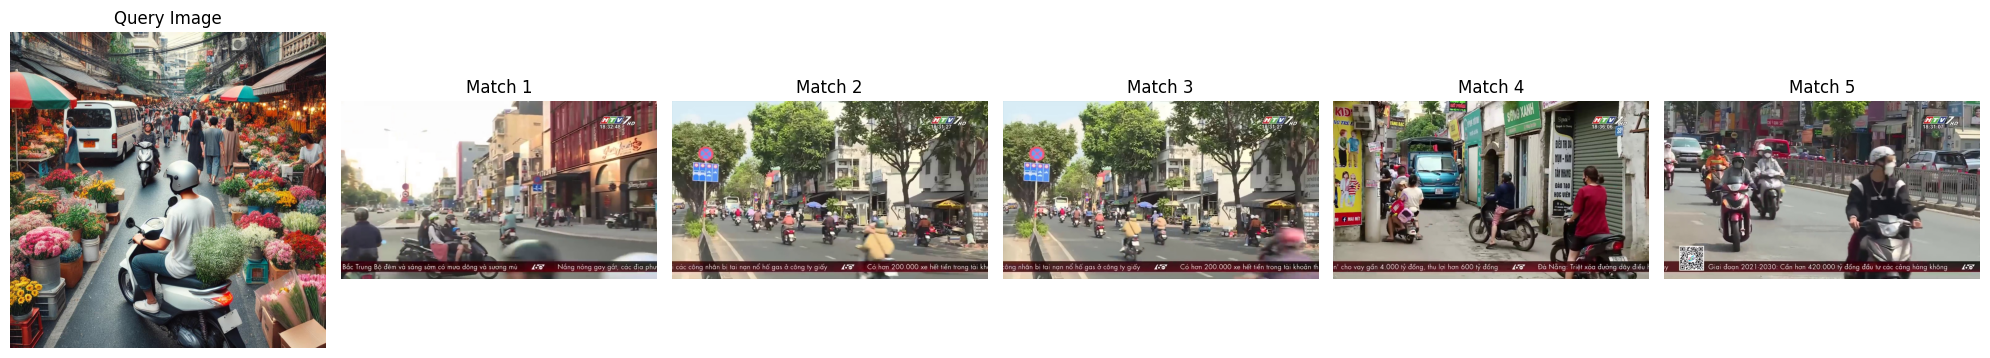

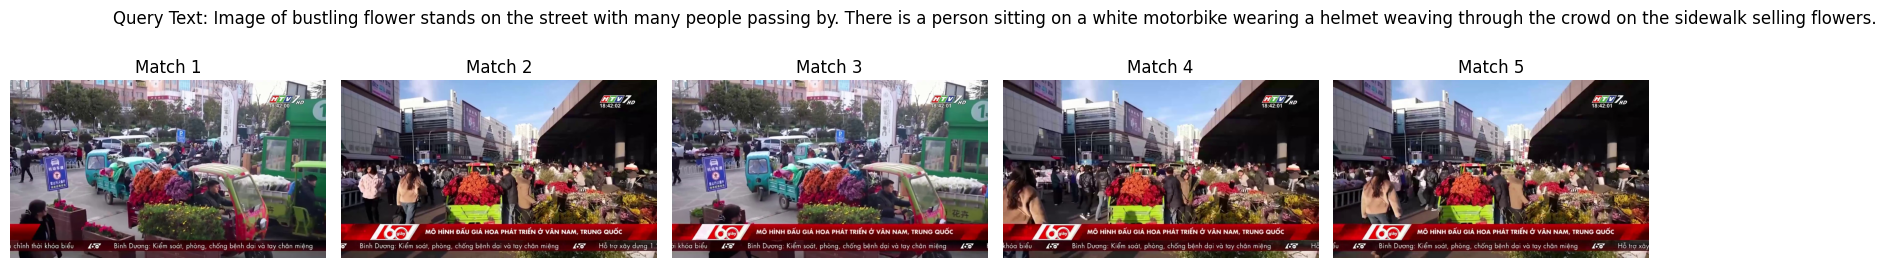

In [7]:

# Text-based search
text_query = "Image of bustling flower stands on the street with many people passing by. There is a person sitting on a white motorbike wearing a helmet weaving through the crowd on the sidewalk selling flowers."
print(f"Searching for images matching the text: '{text_query}'")
text_results = retriever.search_with_text(text_query, k=5)

print("Text-based search results:")
for i, (path, score) in enumerate(text_results, 1):
    print(f"{i}. Image: {path}")
    print(f"   Similarity Score: {score:.4f}")
    print(f"   Image ID: {os.path.basename(os.path.dirname(path))}")
    print()

# Visualization (optional)
from PIL import Image
import matplotlib.pyplot as plt

def visualize_results(query, results, is_image_query=True):
    plt.figure(figsize=(20, 4))
    if is_image_query:
        plt.subplot(1, 6, 1)
        plt.imshow(Image.open(query))
        plt.title("Query Image")
        plt.axis('off')
    else:
        plt.figtext(0.5, 0.9, f"Query Text: {query}", ha="center", va="top", fontsize=12)

    for i, (path, _) in enumerate(results, 2 if is_image_query else 1):
        plt.subplot(1, 6, i)
        plt.imshow(Image.open(path))
        plt.title(f"Match {i-1 if is_image_query else i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_results(query_image_path, results)
visualize_results(text_query, text_results, is_image_query=False)